## Analysis of Building GHG Emissions and Derive predictive models.
In this notebook, we are working on a dataset to identify patterns of emission from buildings in Seattle, in relation to their energy consumption. 

Developer : Pratim K Talukdar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import colors


In [2]:
df=pd.read_csv('2016-building-energy-benchmarking.csv')

In [3]:
#Deleting the columns  that are not of interest.
df.drop(['DataYear','PropertyName','Address','City','State','TaxParcelIdentificationNumber', 'PropertyGFAParking','ListOfAllPropertyUseTypes',
         'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',
        'Electricity(kWh)','NaturalGas(therms)','Comments','DefaultData','Outlier'],axis=1,inplace=True)

#Renaming our target column name to make it simple , hereon read GEI as GreenhouseEmissionsIntensity
df.rename(columns={'GHGEmissionsIntensity':'GEI'}, inplace=True)


## Lets see how the buildings are having their primary property types.

In [4]:
#df.BuildingType.unique

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


In [5]:

ct=pd.crosstab(df.BuildingType, df.CouncilDistrictCode)
ct.style.apply(background_gradient,cmap='PuBu',m=ct.min().min(),M=ct.max().max(),low=0,high=0.2)

CouncilDistrictCode,1,2,3,4,5,6,7
BuildingType,,,,,,,
Campus,4,4,5,2,1,0,8
Multifamily HR (10+),0,4,24,3,2,2,75
Multifamily LR (1-4),111,76,228,129,169,91,214
Multifamily MR (5-9),52,32,141,62,35,39,219
NonResidential,92,346,175,156,109,94,488
Nonresidential COS,6,23,11,3,9,7,26
Nonresidential WA,0,0,0,1,0,0,0
SPS-District K-12,17,24,12,11,13,14,7


<i>Interpretation : We can see that most of the buildings covered under study are in the 'Non-residential' category. Furthermore, the districts 2 and 7 has the most number of Non residential buildings. </i>

In [6]:
ct=pd.crosstab(df.BuildingType, df.PrimaryPropertyType)
#ct=pd.crosstab(df.ZipCode, df.YearBuilt).max()

ct.style.apply(background_gradient,cmap='PuBu',m=ct.min().min(),M=ct.max().max(),low=0,high=0.2)


PrimaryPropertyType,Distribution Center,High-Rise Multifamily,Hospital,Hotel,K-12 School,Laboratory,Large Office,Low-Rise Multifamily,Medical Office,Mid-Rise Multifamily,Mixed Use Property,Office,Other,Refrigerated Warehouse,Residence Hall,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Small- and Mid-Sized Office,Supermarket / Grocery Store,University,Warehouse,Worship Facility
BuildingType,,,,,,,,,,,,,,,,,,,,,,,,
Campus,0,0,0,0,4,0,1,1,0,0,4,0,7,0,0,1,0,0,0,0,0,6,0,0
Multifamily HR (10+),0,105,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0
Multifamily LR (1-4),0,0,0,0,0,0,0,984,0,1,11,0,4,0,0,0,0,0,16,1,0,1,0,0
Multifamily MR (5-9),0,0,0,0,0,0,0,0,0,563,8,0,1,0,2,0,0,0,6,0,0,0,0,0
NonResidential,51,0,10,76,39,10,168,2,38,0,102,0,185,12,21,11,91,28,20,288,40,17,180,71
Nonresidential COS,2,0,0,0,0,0,4,0,1,0,8,3,56,0,0,0,0,0,0,4,0,0,7,0
Nonresidential WA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
SPS-District K-12,0,0,0,0,96,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0


<i> Interpretation : Majority of the buildings are low-rise multifamily buildings or mid-rise multifamily buildings. </i>

### Greenhouse gas emissions intensity(GEI) according to District, Building Type, Year Built, and (Largest) property use type

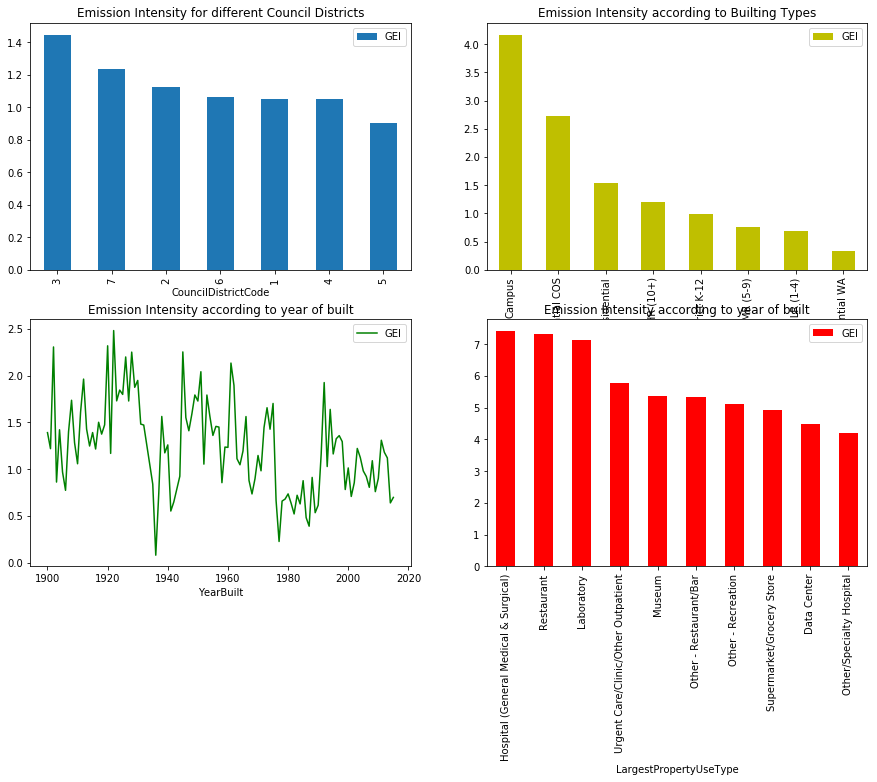

In [7]:
plt.figure(figsize=(15,10))

df.loc[:,['CouncilDistrictCode','GEI']].groupby('CouncilDistrictCode').mean().sort_values('GEI', ascending=False).plot(kind='bar',ax=plt.subplot(2,2,1),title='Emission Intensity for different Council Districts')
df.loc[:,['BuildingType','GEI']].groupby('BuildingType').mean().sort_values('GEI', ascending=False).plot(kind='bar',ax=plt.subplot(2,2,2), color='y', title='Emission Intensity according to Builting Types')
df.loc[:,['YearBuilt','GEI']].groupby('YearBuilt').mean().plot(kind='line',ax=plt.subplot(2,2,3), color='g', title='Emission Intensity according to year of built')
df.loc[:,['LargestPropertyUseType','GEI']].groupby('LargestPropertyUseType').mean().sort_values('GEI', ascending=False).head(10).plot(kind='bar',ax=plt.subplot(2,2,4), color='r', title='Emission Intensity according to year of built')


Interpretations :Few interpretations can be made from the above diagrams:
    1. Districts - 3,7,2 have high GEI, whereas district 5 has low GEI. Both the extremes will be analysed.
    2. Campus and Non-residential COS have high GEI. We will try to know why, and where are the loopholes.
    3. The greenhouse gas intensity of old buildings are high. New buildings fare better, the overall downtrend is visible, but we will need to explain the high fluctuations.
    4. Hospitals, Restaurants and Laboratories account for high Greenhouse gas emissions intensity.

## How numeric variables affect the Greenhouse gas emissions intensity? Lets mine..

First Task : Normalize the numerical variables. We will first copy the dataframe and normalize the variables - 'Latitude', 'Longitude', 'GEI'

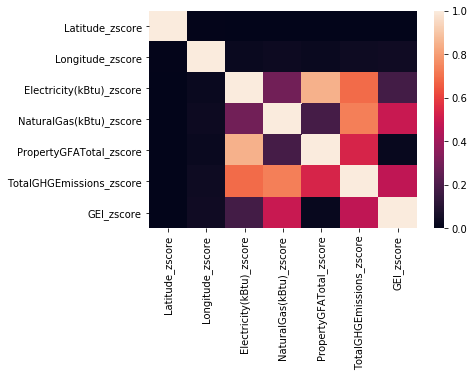

In [8]:
df2=df.copy()

df2=df2.loc[:,['Latitude','Longitude','Electricity(kBtu)','NaturalGas(kBtu)','PropertyGFATotal','TotalGHGEmissions', 'GEI']]
cols = list(df2.columns)
for col in cols:
    col_zscore = col + '_zscore'
    df2[col_zscore] = (df2[col] - df2[col].mean())/df2[col].std(ddof=0)
    
df2.drop(cols, axis=1, inplace=True)
sns.heatmap(df2.corr(), vmin=0, vmax=1)

Interpretations from the above heatmap:
        1.Strong correlation between Property gross floor area(PropertyGFATotal) and Electricity consumption.
        2. Strong correlation between Natural gas consumption and Total GHG emissions.
        3. Considerably strong relations of electricity consumption with 
        4. Natural gas has more say than electricity on the Greenhouse emission intensity(GEI) of a building.
        5. Latitude nd longitude has no relation with any of the field.

## Plotting the correlation between different numerical variables.

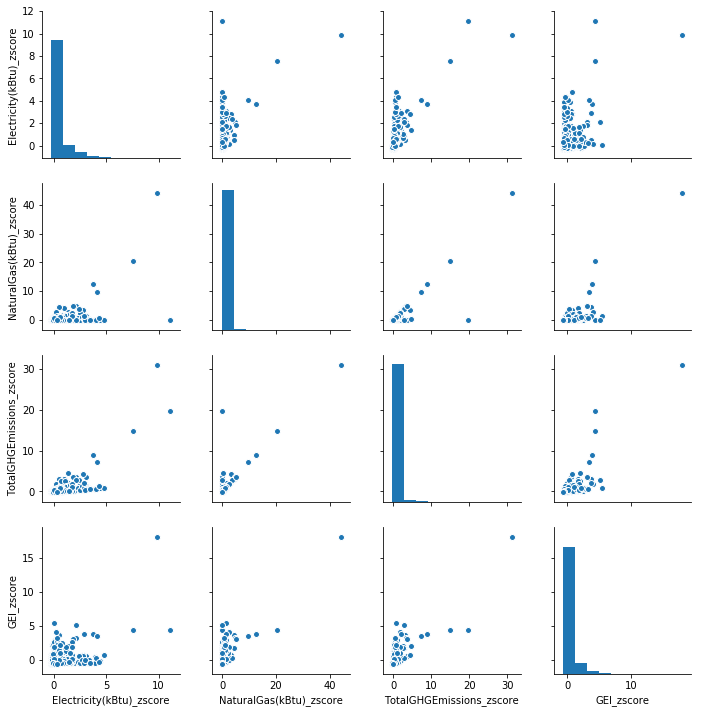

In [9]:
#df2.loc[:,['Electricity(kBtu)_zscore','TotalGHGEmissions_zscore','NaturalGas(kBtu)_zscore']].dtypes
sns.pairplot(df2.loc[0:500,['Electricity(kBtu)_zscore','NaturalGas(kBtu)_zscore','TotalGHGEmissions_zscore', 'GEI_zscore']])



## Plotting Total-GHG-Emissions against Electricity consumption, Natural gas consumption and Total property area

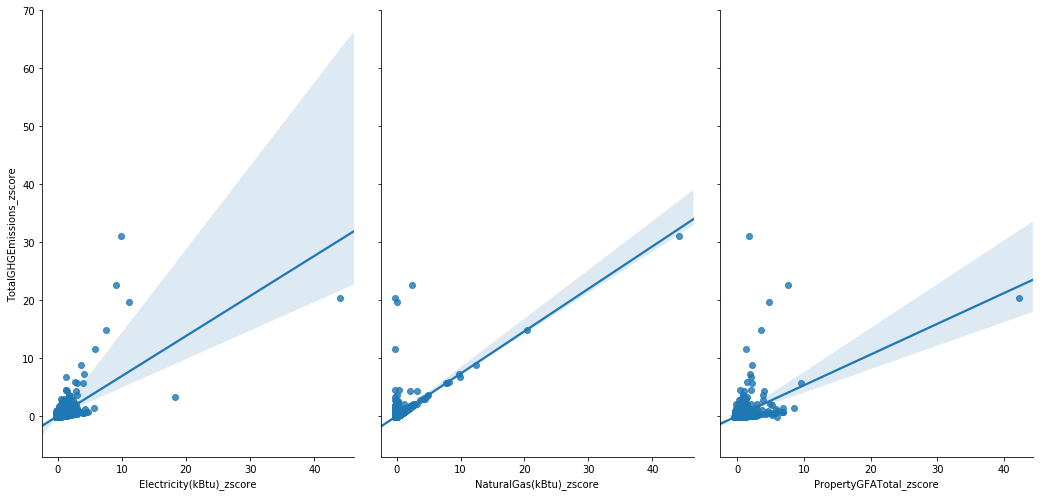

In [10]:
sns.pairplot(df2, x_vars=['Electricity(kBtu)_zscore','NaturalGas(kBtu)_zscore','PropertyGFATotal_zscore'], y_vars='TotalGHGEmissions_zscore',size=7, aspect=0.7, kind='reg')

Interpretation: 
                We can see that Total GHG emission is strongly correlated with Natural Gas consumption, but relatively weakly correlated with Property area and even weak with Electricity consumption.



<Figure size 720x360 with 0 Axes>

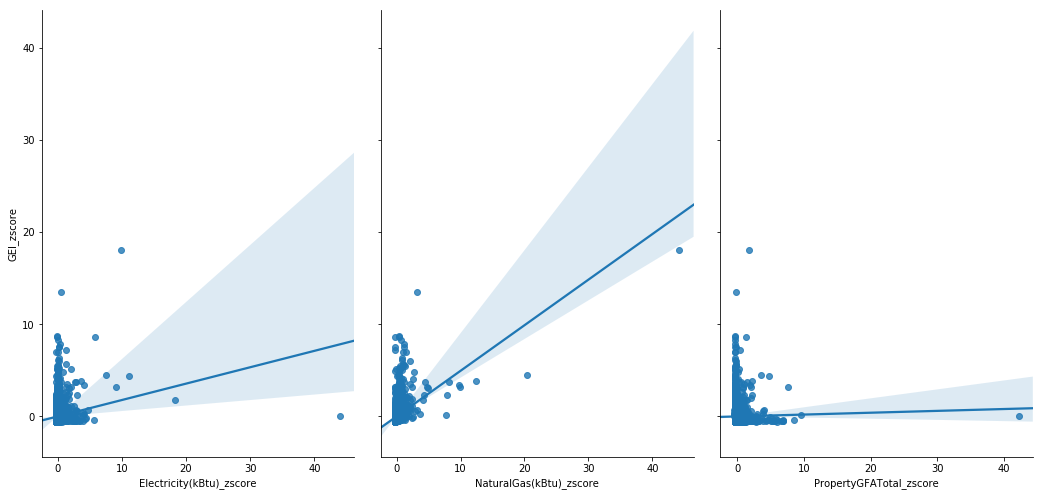

In [11]:
plt.figure(figsize=(10,5))
sns.pairplot(df2, x_vars=['Electricity(kBtu)_zscore','NaturalGas(kBtu)_zscore','PropertyGFATotal_zscore'], y_vars='GEI_zscore',size=7, aspect=0.7, kind='reg')

Interpretation:
        1.Weak correlation of GEI with Electricity(kBtu) consumption.
        2.Strong correlation of GEI with natural gas consumption.
        3.Virtually no correlation of GEI with property floor area.

## Creating dummy variables out of ComplianceStatus

In [27]:
print(df.ComplianceStatus.unique())
d=pd.get_dummies(df.ComplianceStatus)
d.drop(columns=['Error - Correct Default Data'], inplace=True)
df=pd.concat([df,d], axis=1)

['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']


## Little bit of handling missing data

we can see from an earlier analysis, that exactly 9 rows in each of the columns - Electricity(kBtu), NaturalGas(kBtu), and TotalGasEmissions have missing values. We are suspicious, if these columns have missing values for the same rows. Lets check.

In [14]:
df_test=df.loc[(df['Electricity(kBtu)'].isnull()) & (df['NaturalGas(kBtu)'].isnull()) & (df['TotalGHGEmissions'].isnull())]
df_test.shape

(9, 32)

Well, our suspicion has proven right. So, we will drop these rows.

In [24]:
df.dropna(subset=['Electricity(kBtu)'],inplace=True)

## Linear Regression: To find out the value of GEI as function of combination of different variables.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
linreg=LinearRegression()
X=df.loc[:, ['Electricity(kBtu)','NaturalGas(kBtu)','PropertyGFATotal']]
y=df.loc[:,'TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

linreg.fit(X_train, y_train)
y_test.sort_values().tail()

print(linreg.coef_, linreg.intercept_)

(2020, 3) (1347, 3) (2020,) (1347,)
[ 2.99195778e-05  4.39802492e-05 -7.34774658e-04] 23.313716464959725


In [17]:
y_pred=linreg.predict(X_test)
y_pred.shape

(1347,)

In [18]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

314.80733305082936


In [19]:
from sklearn.model_selection import cross_val_score
lm=LinearRegression()
score=cross_val_score(lm, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('RMSE error values are:\n', np.sqrt(-score))

RMSE error values are:
 [149.19400819 122.85252295 517.57622229 193.04880297  79.16386346
 140.02751595  88.50536161 660.60619527 345.03512004  63.89413254]


<font color='red'> END OF ANALYSIS </font>

## <i> ROUGH EXPERIMENTS : Trying out MinMax Scaler <i>

#### Some experiment of normalization using Min Max scaler

In [30]:
from sklearn.preprocessing import MinMaxScaler
s=pd.DataFrame([[12, 5, 34, 24],[20,10,20,10],[15,13,6,7]], columns=['a','b','c','d'])
s
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(s)
print(s)
print(x_scaled)

    a   b   c   d
0  12   5  34  24
1  20  10  20  10
2  15  13   6   7
[[0.         0.         1.         1.        ]
 [1.         0.625      0.5        0.17647059]
 [0.375      1.         0.         0.        ]]


In [21]:
## DUMMY EXPERIMENTATION..
s=pd.DataFrame([['North', 5, 34, 24],['East',10,20,10],['West',13,6,7],['South',16,12,8]], columns=['a','b','c','d'])
s
d=pd.get_dummies(s['a'])
d
c=pd.concat([s,d], axis=1)
c

,a,b,c,d,East,North,South,West
0,North,5,34,24,0,1,0,0
1,East,10,20,10,1,0,0,0
2,West,13,6,7,0,0,0,1
3,South,16,12,8,0,0,1,0


FEATURE ENGINEERING TUTORIAL:
https://www.analyticsvidhya.com/blog/2018/08/guide-automated-feature-engineering-featuretools-python/